# Feature Matching

## Corner detection for matching
We have spent a good deal of time thinking about how to extract *good* points from images, where *good* in this case implies that they change alot in all directions, which makes them possible to localize.  Because these features are relatively rare (how many really good keypoints did you extract in the last notebook?), it stands to reason that they might be robust to changes in the image.  **Take two overlapping photos with a phone or webcam.  Run Harris Corner Detection on each, and think about whether the keypoints extracted in image 1 correspond to those in image 2.  How much of the time?**


In [9]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
from math import exp
import math
from matplotlib.pyplot import figure
# A generic G function
def gn(u, v, img):
    
    return img[u,v]
    return 0.0

# Our h gauss function
def hgauss (j, k, img, rad, sigma):

    val = j*j + k*k
    val = val / (2 * sigma * sigma)
    val = exp (-val)
    
    return val * 1 / ((2 * rad + 1)^2)

# A generic convolution function
def convolveGauss(g, h, img, rad, sigma):
    out = np.zeros((img.shape[0], img.shape[1])) # Output image has 2 less rows and columns from convolution
    
    ja = list(range(-rad, rad + 1)) 
    ka = list(range(-rad, rad + 1))
    
    # Simply loop through all pixels in the image and apply g and h to those pixels
    for u in range(rad, img.shape[0] - rad - rad):
        for v in range(rad, img.shape[1] - rad - rad):
            sum = 0.0
            
            for j in ja:
                for k in ka:
                    sum += g(u + j, v + k, img) * h(j, k, img, rad, sigma)
                    
                    
            out[u, v] = sum
    
    return out

def hsobel(j, k, img, rad, sigma):
    matr = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    j = j + 1
    k = k + 1
    return matr[j, k]

def hsobelT(j, k, img, rad, sigma):
    matr = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    matr = np.transpose(matr)
    j = j + 1
    k = k + 1
    return matr[j, k]

def Harris(img, radius=1, sd=2.0):
    Iu = convolveGauss(gn, hsobel, img, 1, 1)
    Iv = convolveGauss(gn, hsobelT, img, 1, 1)
    

    
    Iuu = np.multiply(Iu, Iu)
    Ivv = np.multiply(Iv, Iv)
    Iuv = np.multiply(Iu, Iv)

    
    Iuu = convolveGauss(gn, hgauss, Iuu, radius, sd)
    Ivv = convolveGauss(gn, hgauss, Ivv, radius, sd)
    Iuv = convolveGauss(gn, hgauss, Iuv, radius, sd)
    
    num = (np.multiply(Iuu, Ivv) - np.multiply(Iuv, Iuv))
    denom = Iuu + Ivv + 0.000001
    
    
    result = np.divide(num, denom)
    return result

def isLocalMax(img, x, y):
    for i in range(-1, 2):
        for j in range(-1, 2):
            
            if (i == 0 and j == 0):
                continue
                
            nx = i + x
            ny = j + y
            
            
            if nx < 0 or nx > img.shape[0]:
                continue
            if ny < 0 or ny > img.shape[1]:
                continue
            if img[x,y] <= img[nx, ny]:
                return False
    return True
            

def localMax(img):
    xpoints = []
    ypoints = []
    intensity = []
    for y in range(img.shape[1]):
        for x in range(img.shape[0]):
            if isLocalMax(img, x, y):
                xpoints.append(x)
                ypoints.append(y)
                intensity.append(img[x,y])
    return xpoints, ypoints, intensity

def convertListsIntoPoints(X, Y, IN):
    points = []
    for i in range(len(X)):
        points.append((X[i], Y[i], IN[i]))
    return points

def convertPointsIntoLists(p):
    xlist = []
    ylist = []
    ilist = []
    for i in p:
        xlist.append(i[0])
        ylist.append(i[1])
        ilist.append(i[2])
    return (xlist, ylist, ilist)


def cmp_points(a, b):
    x, y, i1 = a
    x, y, i2 = b
    
    if (i1 > i2):
        return 1
    elif i1 == i2:
        return 0
    else:
        return -1
    

def filterPoints(points, n=100):
    points = sorted(points, key=lambda x: x[2], reverse=True)
    return points[0:n]

def anms(points, n=100, c=0.9):
    newpoints = []
    
    for (x1, y1, i1) in points:
        x0 = 0
        y0 = 0
        i0 = 0
        d0 = 0
        for (x2, y2, i2) in points:
            distance = math.sqrt(((x2 - x1) ** 2) + ((y2 - y1) ** 2))
            
            if i2 * c > i1:
                if i0 == 0:
                    i0 = i2
                    x0 = x2
                    y0 = y2
                    d0 = distance
                
                
                if distance < d0:
                    d0 = distance
                    x0 = x2
                    y0 = y2
        if d0 > 0:
            newpoints.append((x0, y0, i0))
        
        newpoints = sorted(newpoints, key=lambda x: x[2], reverse=True)
        finalpoints = []
        
    px = -1
    py = -1
    for (x, y, i) in newpoints:
            if x != px or y != py:
                px = x
                py = y
                finalpoints.append((x, y, i))
                if (len(finalpoints) == n):
                    return finalpoints

    return finalpoints

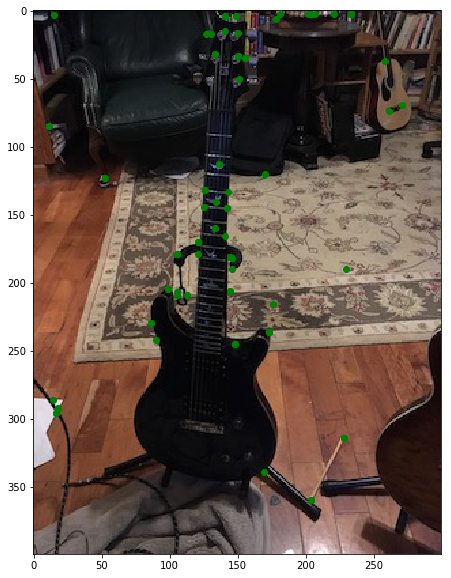

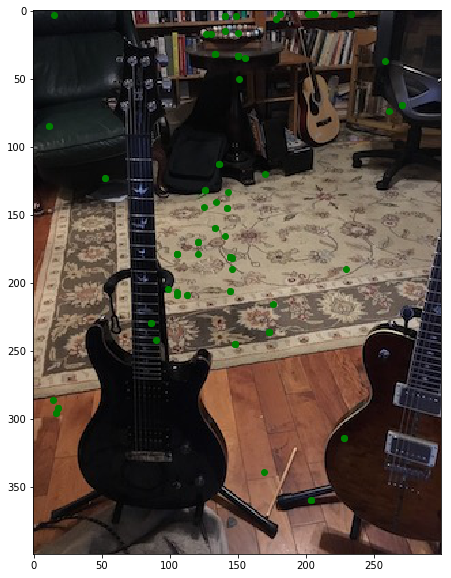

In [10]:
I1 = plt.imread("image_1.jpg")
I2 = plt.imread("image_2.jpg")

g1 = I1.mean(axis=2)
g2 = I1.mean(axis=2)

h1 = Harris(g1)
h2 = Harris(g2)

x1, y1, in1 = localMax(h1)
x2, y2, in2 = localMax(h2)

p1 = convertListsIntoPoints(x1, y1, in1)
p2 = convertListsIntoPoints(x2, y2, in2)

p1 = anms(p1)
p2 = anms(p2)

x1, y1, in1 = convertPointsIntoLists(p1)
x2, y2, in2 = convertPointsIntoLists(p2)

plt.figure(figsize=(10,10))
plt.imshow(I1)

plt.scatter(y1, x1, c='g')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(I2)

plt.scatter(y2, x2, c='g')
plt.show()

## Descriptor extraction
Of course, having to determine matches by hand would go against our principles of automation.  What we want is to determine the correspondences between features in two (or more) images automatically.  While your readings of Szeliski 4.1 have probably made you think that this is a complicated process involving histograms of gradients and complex transforms of image patches, we can produce a surprisingly effective keypoint matching technique using simple sum square error.  First, we need to come up with our feature *descriptor*.  This is just a little chunk of data that describes our keypoint.  It needs to cover some area: just recording the intensity of the pixel at the corner isn't going to do the trick because this value is so non-unique.  At the same time, it shouldn't be too big: matching areas that are too large is expensive and potentially leads to some confusion between keypoints whose feature descriptors overlap in image space.  For now, for each keypoint let's just extract the image intensities of an $l \times l$ patch centered at the keypoint location.  While we could do something more fancy, let's call this little patch of image centered at the keypoint our *descriptor*.  **Extract descriptors for the top n=100 keypoints in both the images taken above.  (Hint: l=21 is often a good choice).**

In [12]:
def descriptorForPoint(img, point, r=10):
    x, y, i = point
    deltas = [x for x in range(-r, r + 1)]
    descriptor = []
    for i in deltas:
        for j in deltas:
            nx = x + i
            ny = y + j
            #print(nx, ny)
            if nx > 0 and nx < img.shape[1] and ny > 0 and ny < img.shape[0]:
                descriptor.append(img[nx][ny])
            else:
                return []
    return (x, y, descriptor)

def descriptorsForPoints(img, points, r=10):
    descriptors = []
    for p in points:

        d = descriptorForPoint(img, p, r=r)
        if len(d) > 0:
            descriptors.append(d)
    return descriptors

def normalizeDescriptor(d):
    x, y, d = d
    
    mean = np.mean(d)
    std = np.std(d)
    nd = []
    for i in d:
        i = i - mean
        i = i / std
        nd.append(i)
    return (x, y, nd)

def normalizeDescriptors(D):
    nd = []
    for i in D:
        nd.append(noramlizeDescriptor(i))
    return nd

def descriptorScore(d1, d2):
    score = 0
    x1,y1,d1 = d1
    x2,y2,d2 = d2
    
    for i in range(len(d1)):
        score += (d1[i] - d2[i]) ** 2
    return score

# Returns the best descriptor matches in d2 for each element in d1
def bestDescriptorMatches(d1, d2):
    bestDescriptors = []
    for i in d1:
        bestD = 0
        bestScore = 10000000000
        for j in d2:
            score = descriptorScore(i, j)
            if score < bestScore:
                bestScore = score
                bestD = j
        bestDescriptors.append(bestD)
    return bestDescriptors

def bestDescriptorMatchesThr(d1, d2, r=0.5):
    usedD1 = []
    bestDescriptors = []
    for i in d1:
        
        bestD = 0
        bestScore = 10000000000
        secondBestScore = 10000000001
        
        dlist = []
        for j in d2:
            score = descriptorScore(i, j)
            if score < bestScore:
                secondBestScore = bestScore
                bestScore = score
                bestD = j
                
        if (secondBestScore * r >= bestScore):
            usedD1.append(i)
            bestDescriptors.append(bestD)
    return usedD1, bestDescriptors

## Descriptor matching
Now that we have extracted features, we need to form correspondences between features in each image via *matching*.  While there are many more efficient ways to perform feature matching, oftentimes the simplest and most effective method is the so-called brute force method: for each descriptor in image 1, compare it to each descriptor in image 2, and determine the one that is the best match.  To do this we need to define a mathematical value for what constitutes a good match.  In this case, I suggest using *z-normalized sum squared error*, e.g.

$$
\hat{D}_i = \frac{D_i - \bar{D_i}}{\mathrm{std}(D_i)}
$$
$$
\hat{D}_j = \frac{D_j - \bar{D_j}}{\mathrm{std}(D_j)}
$$
$$
E_{ij} = \sum_{p} (D_{i,p} - D_{j,p})^2, 
$$
where $D_i$ is the $i-$th keypoint descriptor for image 1 and $D_j$ is the $j-$th keypoint descriptor for image 2.  The z-normalization helps to ameliorate difficulties associated with changes in lighting and image intensity.  **Compute $E_{ij}$ for each pair of descriptors, and find the match for which $E_{ij}$ is smallest.  Plot the two images side by side and overlay lines connecting keypoints in each image to their best match in the other image.** An example might look like this:
<img src="unfiltered_matches.png">

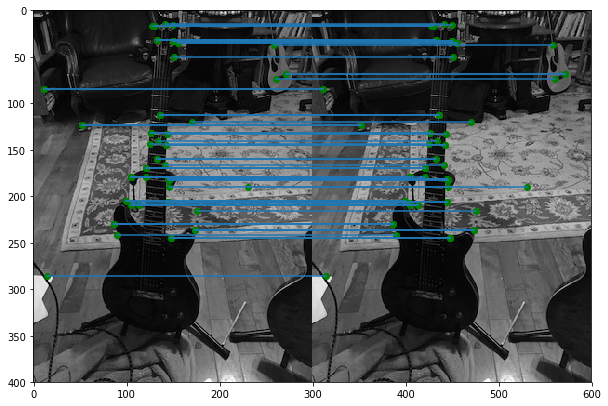

In [17]:
imgcomb = np.zeros((g1.shape[0], g1.shape[1] * 2))

for i in range(g1.shape[0]):
    for j in range(g1.shape[1]):
        imgcomb[i][j] = g1[i][j]
        
for i in range(g2.shape[0]):
    for j in range(g2.shape[1]):
        imgcomb[i][j + g2.shape[1]] = g2[i][j]

d1 = descriptorsForPoints(g1, p1)
d2 = descriptorsForPoints(g2, p2)

b = bestDescriptorMatches(d1, d2)

x1, y1, ilist = convertPointsIntoLists(d1)
x2, y2, ilist = convertPointsIntoLists(b)


x2 = np.array(x2)
y2 = np.array(y2)

x2 = x2 # + g2.shape[1]
y2 = y2 + g2.shape[1]


from matplotlib.lines import Line2D



fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(imgcomb, cmap='gray')
for i in range(len(x1)):
    ax.add_line(Line2D([y1[i], y2[i]], [x1[i], x2[i]]))
    #plt.plot(y1[i], x1[i], y2[i], x2[i], '--', linewidth=5, color='firebrick')

plt.scatter(y1, x1, c='g')
plt.scatter(y2, x2, c='g')
plt.show()

Notice the plethora of spurious matches.  We need some way to pare down these matches, keeping only ones that are *robust*.  While it might be tempting to simply threshold on the value of $E_{ij}$, it has been shown (in the Lowe paper assigned as the grad increment) that a better method is to *threshold on the ratio between the best and second best keypoint match*, which is to say that we want to keep matches for which:
$$
E_{i,\mathrm{best}} > r E_{i,\mathrm{second best}},
$$
where $r$ is a threshold value, often taken as $r\in[0.5,0.7]$.  This test ensures that matches are highly unique, and that our procedure isn't arbitrarily choosing between two or more similarly good (or bad) matches.  **Run this test on your computed keypoint matches, filtering out all the matches that fail the test.  Recreate the figure from the above section, but only keeping the matches that pass the ratio test.**


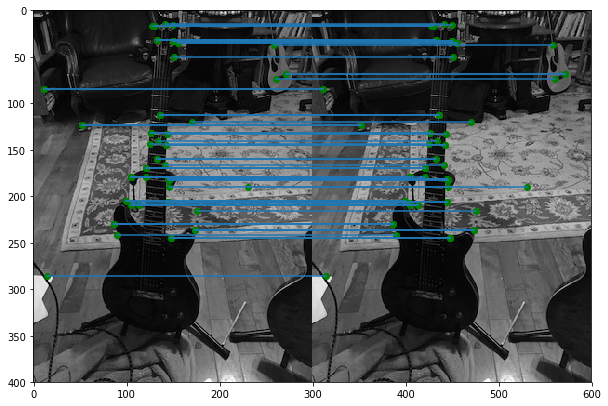

In [18]:
d1 = descriptorsForPoints(g1, p1)
d2 = descriptorsForPoints(g2, p2)

d1, b = bestDescriptorMatchesThr(d1, d2)

x1, y1, ilist = convertPointsIntoLists(d1)
x2, y2, ilist = convertPointsIntoLists(b)

x2 = np.array(x2)
y2 = np.array(y2)

x2 = x2 # + g2.shape[1]
y2 = y2 + g2.shape[1]


from matplotlib.lines import Line2D



fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(imgcomb, cmap='gray')
for i in range(len(x1)):
    ax.add_line(Line2D([y1[i], y2[i]], [x1[i], x2[i]]))
    #plt.plot(y1[i], x1[i], y2[i], x2[i], '--', linewidth=5, color='firebrick')

plt.scatter(y1, x1, c='g')
plt.scatter(y2, x2, c='g')
plt.show()